In [ ]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
"""Data preprocessing for HCMC survey dataset"""

__author__ = "Anna Buch, Heidelberg University"
__email__ = "a.buch@stud.uni-heidelberg.de"

## Feature selection done by eXtreme Gradient Boosting (XGBoost)


In [1]:
import os, sys
import copy as cp
import numpy as np
import pandas as pd

from sklearn.metrics import f1_score, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split, StratifiedKFold, RepeatedStratifiedKFold, RepeatedKFold, cross_val_score, cross_validate
from sklearn.impute import SimpleImputer
from xgboost import XGBClassifier, plot_importance

from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline  # make sure not to mix it with sklearn Pipeline
from collections import Counter

import pickle
import joblib
import matplotlib.pyplot as plt
import seaborn as sns


sys.path.insert(0, "../../../")
import utils.utils_feature_selection as fs
import utils.utils_evaluation as e
import utils.utils_figures as f
import utils.settings as s
import utils.pipelines_discretize as p

s.init()
seed = s.seed

pd.set_option('display.max_columns', None)
plt.figure(figsize=(20, 10))


import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

c:\Anaconda\envs\py396_c3\lib\site-packages\rpy2\robjects\packages.py:367: UserWarning: The symbol 'quartz' is not in this R namespace/package.
  warnings.warn(


<Figure size 2000x1000 with 0 Axes>

In [2]:
df_candidates = pd.read_excel("../../../input_survey_data/input_data_business.xlsx")
df_candidates.tail(2)


,Target_contentloss_euro,Target_businessreduction,inundation_duration_h,water_depth_cm,contaminations.0,flowvelocity,warning_time_h,emergency_measures.1,emergency_measures.2,emergency_measures.3,emergency_measures.4,emergency_measures.6,emergency_measures.7,emergency_measures.8,emergency_measures.9,overall_problem_house,protect_valuables_impl,water_barriers_impl,pumping_equipment_impl,elevation_building_impl,resistant_material_building_impl,electricity_higher_impl,flood_protections_impl,flood_experience,elevation_building_height_cm,elevation_rel2surrounding_cat,bage,b_area,hh_monthly_income_cat,shp_owner,shp_sector,shp_employees,shp_avgmonthly_sale_cat,shp_finance_investments,shp_profits_last5years,shp_risk_tolerance,shp_monetary_resources4prevention,resilience_city_protection,resilience_more_future_affected,resilience_govern_warnings_helpful,resilience_govern_careing,resilience_left_alone,resilience_neighbor_management,perception_who_responsible4protection.Rank1,perception_private_economy_future,contaminations_light,contaminations_heavy,shp_suppliers_HCMC,shp_content_value_euro,elevation_m,shp_registered_capital_euro
395,0.0,NaN,4.0,70.0,0,1,NaN,1,0,1,0,1,0,0,0,1,1,5,1,1,5,5,5,5,70.0,1,NaN,130.0,NaN,1,17,2,3,1,4.0,3.0,3.0,1.0,5.0,1.0,1.0,5,1.0,2.0,3.0,1,0,1,NaN,1.83886,11047.7
396,0.0,0.0,3.0,100.0,0,1,NaN,1,0,1,0,0,0,0,0,0,1,5,5,5,5,5,5,4,NaN,0,5.0,33.0,1.0,1,11,2,3,1,4.0,3.0,4.0,NaN,NaN,NaN,NaN,5,NaN,3.0,3.0,1,0,1,NaN,1.87277,736.5


In [3]:
## delete features with more than 10% missing values

# print(df_candidates.isna().sum(axis=0).sort_values(ascending=False))
print("Features sorted b their number of nan values\n", (df_candidates.isna().mean()*100).sort_values(ascending=False).head(5))
print(df_candidates.shape)
## --> keep these feature due that they could be important for model performance (based on findings from other studies)


Features sorted b their number of nan values
 warning_time_h                  77.581864
elevation_building_height_cm    15.869018
shp_content_value_euro          15.869018
shp_registered_capital_euro     11.838791
Target_businessreduction         9.068010
dtype: float64
(397, 51)


In [4]:
# X = pd.DataFrame()
# X = df_candidates.drop(["Target_contentloss_euro", "Target_businessreduction"], axis=1)

# scaler = MinMaxScaler()
# d = scaler.fit_transform(X)
# X_scaled = pd.DataFrame(d, columns=X.columns)

# for f in ["warning_time_h", "shp_registered_capital_euro", "elevation_building_height_cm",  "shp_content_value_euro"]:
#     X_scaled[f"{f}"] = X_scaled[f"{f}"].replace(np.nan, np.nanmedian(X_scaled[f"{f}"]))

# X_scaled_drop_nan = X_scaled.dropna()

# df_vif = fs.vif_score(X_scaled_drop_nan).reset_index(drop=True)
# print(df_vif.sort_values("vif_scores", ascending=False).head(15)  )

### Target varibale distirbution

(1.0, 20000.0)

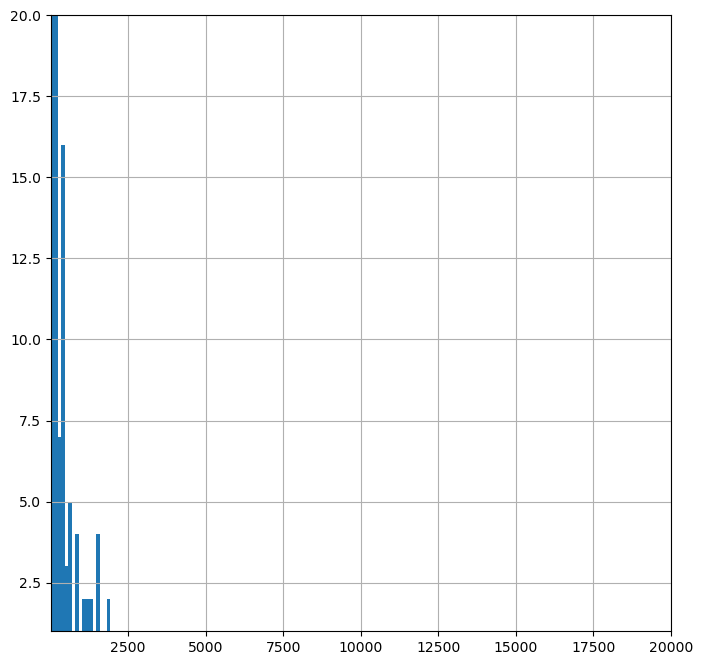

In [5]:
closses = df_candidates.Target_contentloss_euro[df_candidates.Target_contentloss_euro != 0.0 ]
closses.describe()


closses.hist(bins=2000, figsize=(8, 8))
plt.ylim(1, 20)
plt.xlim(1, 20000)

## Fit model 

In [6]:
param_grid = {'xgbclassifier__n_estimators': [10, 20 ,30, 40, 50, 60, 100],
              'xgbclassifier__max_depth': [1, 2, 3, 4, 5, 6],
              'xgbclassifier__colsample_bytree': [0.005, 0.1, 0.3, 0.5], # Percentage of columns to be randomly samples for each tree
              'xgbclassifier__colsample_bynode': [0.05, 0.1, 0.2], # nbr of feautres for each split point
              'xgbclassifier__learning_rate': [0.001, 00.1, 0.1, 0.3, 0.5, 0.7],  # == eta
              'xgbclassifier__gamma': [0.5, 1, 2, 3] , # min_split_loss -  larger gamma is, the more conservative the algorithm is
              #'subsample': 0.8  # define subsample of train st, xgb has not bootstrapping
              'xgbclassifier__reg_alpha': [0, 0.5, 1.0, 2.0],   # Lasso Regularization term on weights , higher values = more consrvative 
              'xgbclassifier__reg_lambda': [0.0, 0.5, 1.0, 2.0],  # Ridge Regularization term on weights ,  higher values = more consrvative
              'xgbclassifier__min_child_weight': [0, 1, 2, 3, 4,],
              'xgbclassifier__objective': [None, 'reg:linear'],
              }

In [8]:
## iterate over both targets and store results 
#sampling_strategy = "majority"
#"not minority" # =resample all classes bot not smallest class 
#"majority"= only largest class is et to size of smallest class, intermediate classe are untouched

zero_loss_ratio = 0.25
fi_threshold = 0.000

def ratio_multiplier(y, sampling_stategy=zero_loss_ratio):
    """"
    https://imbalanced-learn.org/stable/auto_examples/api/plot_sampling_strategy_usage.html#sphx-glr-auto-examples-api-plot-sampling-strategy-usage-py
    y : y train
    sampling_stategy = str defineing imblearn stategy or float between 0-1.0 defining ratio to which y is reduced .e.g. (0.75 >- y will be 75% of its former size)
    """
    # if sampling_stategy == "majority": 
    #     return sampling_stategy
    # else:
    multiplier = {0: zero_loss_ratio} # set only zero loss class to the half or 3/4 of its size
    target_stats = Counter(y)
    for key, value in target_stats.items():
        if key in multiplier:
            target_stats[key] = int(value * multiplier[key])
    return target_stats



targets = ["Target_contentloss_euro", "Target_businessreduction"]
importances_threshold = {"Target_contentloss_euro": 0.000, "Target_businessreduction": 0.000 }

# fi_plots =  {"Target_contentloss_euro": None, "Target_businessreduction": None }

plt.ioff()  # Prevent plt showing stuff


for target in targets:


    ## iterate over piplines. Each piplines contains precrosseing methods and several  classifier
    pipelines = ["pipe_us_xgb", "pipe_ximput_us_xgb"]
        

    for pipe_name in pipelines:

        print( f"\nApply XGBoost on {target}, with pipeline {pipe_name}:")

        ## load sinlge pipeline
        pipe = joblib.load(f'./pipelines/{pipe_name}.pkl')
        
        
        df_candidates_t = df_candidates

        ## TEST run xgb with and without nan in X
        ## clean df from remaining records containg nan
        #df_candidates_t = df_candidates_t.dropna()
        #df_candidates_t = df_candidates_t[df_candidates_t[target]!=0.0]

        #print("Amount of missing target values should be zero: ", df_candidates_t[target].isna().sum())
        print("Uses ", df_candidates_t.shape[0], " records, from those have ", 
            { (df_candidates_t[target][df_candidates_t[target]==0.0]).count() }, f" records zero {target.split('_')[1]}")


        ## drop samples where target is nan
        print(f"Dropping {df_candidates_t[f'{target}'].isna().sum()} records from entire dataset due that these values are nan in target variable")
        df_candidates_t = df_candidates_t[ ~df_candidates_t[f"{target}"].isna()]

            
            
        # Discretize target variable 
        print("Discretization of target:")

        target_c = target + "_c"

        no_contentloss = df_candidates_t[df_candidates_t[target]==0.0]
        no_contentloss[target_c] = 0 #"no loss"
        contentloss = df_candidates_t.drop(no_contentloss.index,  axis=0)  # reduce df to not yet discretized records
    
        ## exclude also very high values for content loss
        if target == "Target_contentloss_euro":
            #extreme_high_contenloss = df_candidates_t[df_candidates_t[target] >= extreme_high_lower_bin_boundary]
            #extreme_high_contenloss[target_c] = 4 # "very high"
            #contentloss = contentloss.drop(extreme_high_contenloss.index,  axis=0) #  reduce df to not yet discretized records
            
            ## equal frequency binning for major group of content losses
            contentloss = fs.equal_freq_binning(
                df=contentloss, variable_name=target, 
                cuts=4, group_labels=[1, 2, 3, 4 ], #["low", "medium", "high"], 
                drop_old_variable=False)
            df_candidates_t = pd.concat([no_contentloss, contentloss], axis=0).reset_index(drop=True)
    #        df_candidates_t = pd.concat([no_contentloss, contentloss, extreme_high_contenloss], axis=0).reset_index(drop=True)

        # make for 4 eqal bins for business reduction, due that no extreme high values exists
        if target == "Target_businessreduction":
            contentloss = fs.equal_freq_binning(
                df=contentloss, variable_name=target, 
                cuts=4, group_labels=[1, 2, 3, 4 ],
                drop_old_variable=False)
            df_candidates_t = pd.concat([no_contentloss, contentloss], axis=0).reset_index(drop=True)
        
        df_candidates_t.insert(1, target_c, df_candidates_t.pop(target_c))
        df_candidates_t = df_candidates_t.sort_values(target)  # sort values to assigne later 
                                    #print("check if correct discretized:", df_candidates_t[[target_c, target]].tail(5))  # visual check if correct discretized
        print("check if correct discretized:", df_candidates_t[target_c].value_counts())  # visual check if correct discretized

        ## save distribution of discretized variable for visual check to disk
        fig, ax = plt.subplots(nrows=1, ncols=1)  # create figure & 1 axis
        df_candidates_t[target_c].hist( bins=len( df_candidates_t[target_c].unique())*2-1, grid=False ) # get space between single bars
        fig.tight_layout()
        fig.savefig(f'../../../figures/histo_{target_c}_{pipe_name}_dscrt.png')

        ##impute nans in X if defined in pie
        if pipe_name == "pipe_ximput_us_xgb":
            for c in df_candidates_t.drop(targets, axis=1): 
                df_candidates_t[f"{c}"].fillna(value=np.nanmedian(df_candidates_t[f"{c}"]), inplace=True)
 

        # split into predictors and target variable
        X_unscaled = df_candidates_t.drop([target_c] + targets, axis=1)  # remove targets from X
        y = df_candidates_t[target_c]
        
        ## test train split
        X_train, X_test, y_train, y_test = train_test_split(
            X_unscaled, y, test_size=0.10, 
            random_state=seed, shuffle=True
        )
        eval_set = [(X_test, y_test)]

        ## normalize data 
        X_train, X_test = fs.normalize_X(X_train, X_test)
        
        ## Pre-check class distribution with user-defined balancing stategy
        print("Balancing will result in following class frequencies")
        print(Counter(y_train))
        print(ratio_multiplier(y_train, zero_loss_ratio))

        ## Hyperparmaters and CV
        ## TODO adapt repeats + find better method maybe RepeatedStratifiedKFold
        #cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=seed) 
        cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3)#, random_state=seed)        #  StratifiedKFold = fold contains same percantega of class as in orignal training set, addresees imbalancing
        model_cv = RandomizedSearchCV(
            estimator=pipe, 
            param_distributions=param_grid, 
            cv=cv, 
            #scoring="f1_micro",   #TODO test also e.g "f1" or recall, "neg_mean_absolute_error",
            refit=True,   ## Refit the best estimator with the entire dataset. If “False”, it is impossible to make predictions using this GridSearchCV instance after fitting.
                            ## If refit=False, clf.fit() will have no effect because the GridSearchCV object inside the pipeline will be reinitialized after fit().
                            ## ! When refit=True, the GridSearchCV will be refitted with the best scoring parameter combination on the whole data that is passed in fit()
            #random_state=seed,
        )
        ## Fit model 
        model_cv.fit(X_train, y_train)

        print(f"Best hyperparams: {model_cv.best_params_}")
        # print("Train R^2 Score : %.1f" %model_cv.best_estimator_.score(X_train, y_train))
        #print("MAE of best model: %.1f" %model_cv.best_score_," on iteration ", model_cv.best_estimator_.best_iteration)  

        # fit model again with best hyperparams
        print("Create new XGBoost model based on best hyperparameters")
        model = XGBClassifier(
            n_estimators = model_cv.best_params_['xgbclassifier__n_estimators'], 
            max_depth = model_cv.best_params_['xgbclassifier__max_depth'],
            colsample_bynode = model_cv.best_params_['xgbclassifier__colsample_bynode'],
            colsample_bytree = model_cv.best_params_['xgbclassifier__colsample_bytree'],
            learning_rate = model_cv.best_params_['xgbclassifier__learning_rate'],
            gamma = model_cv.best_params_['xgbclassifier__gamma'],
            reg_alpha = model_cv.best_params_['xgbclassifier__reg_alpha'],  # Lasso Regularization term on weights 
            reg_lambda = model_cv.best_params_['xgbclassifier__reg_lambda'],
            min_child_weight = model_cv.best_params_['xgbclassifier__min_child_weight'],
            #random_state=seed,
        )
        model.fit(X_train, y_train)
        
        ## store best trained model for evaluation
        filename = f'./models_trained/xgboost_{target_c}_{pipe_name}_dscrt.sav'
        #pickle.dump(model_cv.best_estimator_, open(filename, 'wb'))
        pickle.dump(model, open(filename, 'wb'))

        ## Evaluate model
        # print(f"Training set score (R^2): {round(model.score(X_train, y_train), 2)}")  # how well did the model on the training set
        # print(f"Test set score (R^2): {model_cv.score(X_test, y_test)}")   # .. compared to the unseen test set for overfitting - acutal not needed
        # r2 = variance explained by model / total variance --> higher r2= better fitted model

        ## get signifcant features based on absolute coeff values
        print("\nSelect features based on permutation feature importance")

        # ## select significant features byPermuation feature importance
        importances = e.permutation_feature_importance(model, X_test, y_test, repeats=5, seed=seed)

        df_importance = pd.DataFrame(
            {"importances" : importances[0]},
            index=X_train.columns.to_list(),
            ) 
        df_importance = df_importance.sort_values("importances", ascending=False)  # get most important features to the top
        print("Most important features:", df_importance.iloc[:5].index.to_list())
        df_importance = df_importance.loc[df_importance.importances >= fi_threshold, : ]
        #df_importance.head(5)
        # ## write selected predictors and response to disk
        fs.save_selected_features(
            X_train, 
            pd.DataFrame(y_train, columns=[target_c]), 
            df_importance.T.columns, 
            filename=f"../../../input_survey_data/fs_xgboost_{target_c.split('_')[1]}_{pipe_name}_dscrt.xlsx"
        )

        ## evaluate
        ## print evaluation report + check for overfitting 
        print("\nTraining set")
        y_pred_train = model.predict(X_train)
        #y_pred_train = model_cv.best_estimator_.predict(X_train)
        print(f"Training set score (F1): {round(f1_score(y_train, y_pred_train, average='micro'), 2)}") 
        # average="micro"
        #e.evaluation_report(y_train, y_pred_train)

        print("\nTesting set")
        y_pred = model.predict(X_test)
        #e.evaluation_report(y_test, y_pred)
        print(f"Test set score (F1): {round(f1_score(y_test, y_pred, average='micro'), 2)}") 

        ## confusion matrix
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,8))  # create figure & 1 axis
        sns.heatmap(confusion_matrix(y_test, y_pred), ax=ax, annot=True)
        fig.tight_layout()
        fig.savefig(f'../../../figures/confusionmatrix_{target_c}_discretized.png')

        


Apply XGBoost on Target_contentloss_euro, with pipeline pipe_us_xgb:
Uses  397  records, from those have  {226}  records zero contentloss
Dropping 15 records from entire dataset due that these values are nan in target variable
Discretization of target:
156 records are euqally split into categories, so that same number of records is in each class (equal frequency binning) 
Group labels and bins : [1, 2, 3, 4] Target_contentloss_euro
(7.399, 39.7]        41
(137.95, 382.7]      40
(382.7, 224190.4]    38
(39.7, 137.95]       37
Name: count, dtype: int64
check if correct discretized: Target_contentloss_euro_c
0    226
1     41
3     40
4     38
2     37
Name: count, dtype: int64
Balancing will result in following class frequencies
Counter({0: 203, 3: 38, 1: 36, 2: 35, 4: 31})
Counter({0: 50, 3: 38, 1: 36, 2: 35, 4: 31})
Best hyperparams: {'xgbclassifier__reg_lambda': 1.0, 'xgbclassifier__reg_alpha': 1.0, 'xgbclassifier__objective': 'reg:linear', 'xgbclassifier__n_estimators': 50, 'xgbcla

In [ ]:
#plt.savefig(f"./models_trained/FI_{target}.png", bbox_inches='tight')
#sns_plot.figure.savefig("output.png")
print(model.score(X_train, y_train))
print(model.score(X_test, y_test))


### Reload model

In [ ]:
## reload models

target = targets[0] + "_c"
print(target)

model_eval = pickle.load(open(f"./models_trained/xgboost_{target}.sav", 'rb'))
#model_eval.get_params()
#dir(model_eval)#.feature_importances_[model_eval.feature_importances_>0.015].shape

In [ ]:
model_eval

### Feature importance
Have the same feature importance method across all applied ML models


In [ ]:
# ## Permuation feature importance
# result = e.permutation_feature_importance(model_eval, X_test, y_test, repeats=5, seed=seed)

# df_importance = pd.DataFrame({
#     "name" : X_train.columns.to_list(),
#     "importances" : result[0],
#      }) 
# df_importance = df_importance.sort_values("importances", ascending=False)  # get most important features to the top
# df_importance.head(5)

In [ ]:
# plot feature importance

# f.plot_feature_importance(df_importance.importances, n=10, figure_size=(20, 15), target=target)

fig, ax = plt.subplots(figsize=(12,10))

# drop features which dont reduce the loss
df_importance = df_importance.loc[df_importance.importances >= 0.001, : ] 
#sorted_idx = model_eval.feature_importances_.argsort()
#plt.barh(df_importance.name[-5:], df_importance.importances[-5:])
plt.bar(df_importance.name, df_importance.importances)
#plt.bar(X_train.columns[sorted_idx[:15]], model_eval.feature_importances_[sorted_idx[:15]])
plt.xticks(
   # ticks = range(len(X_train.columns[sorted_idx[:15]])),
   # labels =X_train.columns[sorted_idx[:15],],
    rotation = 90
    )
plt.title(f"Feature Importances for {target}")

plt.show()

##### Hierarchical clustering on Spearman rank correlation

Select only feautres with low collienarity to solve disadvantage of perumation feature importance.
Randomizing one feature would lead to only small importance score - the model performance wouldnt be move influenced - due that the information is included in other correlated features. Removing one feature keeps the similar inforamtion in the other feautres unchanged and the model learns from the correlated feature. Therefore apply hierachical clustering to select less correlated features

See also:
- Brill 2020 (dissertation)
- https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance_multicollinear.html # code example

In [ ]:
# import scipy.cluster.hierarchy as shc

# plt.figure(figsize=(15, 10))
# plt.title("Customers Dendrogram")

# # Selecting Annual Income and Spending Scores by index
# selected_data = X_train.dropna()
# selected_data = selected_data.T # only possible with out nan
# clusters = shc.linkage(selected_data, 
#             method='ward', optimal_ordering=False,
#             metric="euclidean")
# shc.dendrogram(Z=clusters, 
#                #p=20, # p -> value for truncation mode
#                orientation="right",
#                labels=X_train.columns
#                ) 
# plt.show()

# ## TODO adapt with spearman rank order



In [ ]:

# from scipy.stats import spearmanr
# from scipy.spatial.distance import squareform
# from scipy.cluster.hierarchy import ward, dendrogram

# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
# corr = spearmanr(X_unscaled_no_nan).correlation

# # Ensure the correlation matrix is symmetric
# corr = (corr + corr.T) / 2
# np.fill_diagonal(corr, 1)

# # We convert the correlation matrix to a distance matrix before performing
# # hierarchical clustering using Ward's linkage.
# distance_matrix = 1 - np.abs(corr)
# dist_linkage = ward(distance_matrix, checks=False )
# dendro = dendrogram(
#     dist_linkage, labels=X_unscaled_no_nan.columns.tolist(), ax=ax1, leaf_rotation=90
# )
# dendro_idx = np.arange(0, len(dendro["ivl"]))

# ax2.imshow(corr[dendro["leaves"], :][:, dendro["leaves"]])
# ax2.set_xticks(dendro_idx)
# ax2.set_yticks(dendro_idx)
# ax2.set_xticklabels(dendro["ivl"], rotation="vertical")
# ax2.set_yticklabels(dendro["ivl"])
# fig.tight_layout()


In [ ]:
cluster_ids = shc.fcluster(dist_linkage, 1, criterion="distance")
cluster_id_to_feature_ids = defaultdict(list)
for idx, cluster_id in enumerate(cluster_ids):
    cluster_id_to_feature_ids[cluster_id].append(idx)
selected_features = [v[0] for v in cluster_id_to_feature_ids.values()]

X_train_sel = X_train[:, selected_features]
X_test_sel = X_test[:, selected_features]


In [ ]:
## permutation based FI (build in func from skilearn)

# perm_importance = permutation_importance(xgb, X_test, y_test)
# The visualization of the importance:

# sorted_idx = perm_importance.importances_mean.argsort()
# plt.barh(boston.feature_names[sorted_idx], perm_importance.importances_mean[sorted_idx])
# plt.xlabel("Permutation Importance")